# Install SLEAP
Don't forget to set **Runtime** -> **Change runtime type...** -> **GPU** as the accelerator.

In [ ]:
!pip install sleap -qqq
!pip install albumentations -qqq
!pip install nvidia-ml-py3 -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.9/131.9 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 27.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 85.5 MB/s eta 0:

In [ ]:
import os
import gc
import random
import math
import time
import collections
from typing import Sequence, Tuple, Text, Union, Optional, List

import nvidia_smi

import numpy as np
import albumentations as A

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import sleap

sleap.versions()

SLEAP: 1.3.0
TensorFlow: 2.8.4
Numpy: 1.22.4
Python: 3.10.11
OS: Linux-5.10.147+-x86_64-with-glibc2.31


In [ ]:
!pip install wandb -qqq
import wandb
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.1/203.1 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Utils

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def get_vram():
    nvidia_smi.nvmlInit()

    deviceCount = nvidia_smi.nvmlDeviceGetCount()
    for i in range(deviceCount):
        handle = nvidia_smi.nvmlDeviceGetHandleByIndex(i)
        info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
        output = ("Device {}: {}, Memory : ({:.2f}% free): {} (total), {} (free), {} (used)"
              .format(i, nvidia_smi.nvmlDeviceGetName(handle), 100*info.free/info.total, 
                      info.total/(1024 ** 3), info.free/(1024 ** 3), info.used/(1024 ** 3)))

    nvidia_smi.nvmlShutdown()

    return output

def get_param_count(model):
  trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  total_params = sum(p.numel() for p in model.parameters())
  nontrainable_params = total_params - trainable_params

  return trainable_params, nontrainable_params, total_params

In [ ]:
seed = 42
seed_everything(seed)

# Download training data

In [ ]:
!curl -L --output labels.slp https://storage.googleapis.com/sleap-data/datasets/wt_gold.13pt/tracking_split2/train.pkg.slp
!ls -lah

!curl -L --output val_labels.slp https://storage.googleapis.com/sleap-data/datasets/wt_gold.13pt/tracking_split2/val.pkg.slp
!ls -lah

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  619M  100  619M    0     0  66.7M      0  0:00:09  0:00:09 --:--:-- 73.4M
total 620M
drwxr-xr-x 1 root root 4.0K May  8 03:33 .
drwxr-xr-x 1 root root 4.0K May  8 03:25 ..
drwxr-xr-x 4 root root 4.0K May  3 13:30 .config
-rw-r--r-- 1 root root 620M May  8 03:33 labels.slp
drwxr-xr-x 1 root root 4.0K May  3 13:31 sample_data
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 77.2M  100 77.2M    0     0  61.1M      0  0:00:01  0:00:01 --:--:-- 61.1M
total 697M
drwxr-xr-x 1 root root 4.0K May  8 03:33 .
drwxr-xr-x 1 root root 4.0K May  8 03:25 ..
drwxr-xr-x 4 root root 4.0K May  3 13:30 .config
-rw-r--r-- 1 root root 620M May  8 03:33 labels.slp
drwxr-xr-x 1 root root 4.0K May  3 13:31 sample_data
-rw-r--r-- 1 root root

# Load the training data

In [ ]:
# SLEAP Labels files (.slp) can include the images as well as labeled instances and
# other metadata for a project.
labels = sleap.load_file("labels.slp")
labels = labels.with_user_labels_only()
labels.describe()

Skeleton: Skeleton(description=None, nodes=[head, thorax, abdomen, wingL, wingR, forelegL4, forelegR4, midlegL4, midlegR4, hindlegL4, hindlegR4, eyeL, eyeR], edges=[thorax->head, thorax->abdomen, thorax->wingL, thorax->wingR, thorax->forelegL4, thorax->forelegR4, thorax->midlegL4, thorax->midlegR4, thorax->hindlegL4, thorax->hindlegR4, head->eyeL, head->eyeR], symmetries=[wingL<->wingR, eyeL<->eyeR, midlegL4<->midlegR4, forelegL4<->forelegR4, hindlegL4<->hindlegR4])
Videos: ['labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp']
Frames (user/predicted): 1,600/0
Instances (user/predicted): 3,200/0
Tracks: [Track(spawned_on=0, na

In [ ]:
# Let's also do the same for the val labels.
val_labels = sleap.load_file("val_labels.slp")
val_labels = val_labels.with_user_labels_only()
val_labels.describe()

Skeleton: Skeleton(description=None, nodes=[head, thorax, abdomen, wingL, wingR, forelegL4, forelegR4, midlegL4, midlegR4, hindlegL4, hindlegR4, eyeL, eyeR], edges=[thorax->head, thorax->abdomen, thorax->wingL, thorax->wingR, thorax->forelegL4, thorax->forelegR4, thorax->midlegL4, thorax->midlegR4, thorax->hindlegL4, thorax->hindlegR4, head->eyeL, head->eyeR], symmetries=[eyeL<->eyeR, forelegL4<->forelegR4, hindlegL4<->hindlegR4, midlegL4<->midlegR4, wingL<->wingR])
Videos: ['val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp'

In [ ]:
# Labels are list-like containers whose elements are LabeledFrames
print(f"Number of labels: {len(labels)}")

labeled_frame = labels[0]
labeled_frame

Number of labels: 1600


LabeledFrame(video=HDF5Video('labels.slp'), frame_idx=166050, instances=2)

In [ ]:
# LabeledFrames are containers for instances that were labeled in a single frame
instance = labeled_frame[0]
instance

Instance(video=Video(filename=labels.slp, shape=(66, 1024, 1024, 1), backend=HDF5Video), frame_idx=166050, points=[head: (491.6, 187.7), thorax: (474.4, 224.8), abdomen: (459.9, 262.2), wingL: (448.3, 271.7), wingR: (452.1, 273.5), forelegL4: (478.5, 175.9), forelegR4: (499.9, 177.9), midlegL4: (440.6, 216.4), midlegR4: (510.1, 242.7), hindlegL4: (437.2, 234.3), hindlegR4: (490.9, 266.7), eyeL: (477.5, 193.2), eyeR: (498.4, 201.2)], track=Track(spawned_on=0, name='female'))

In [ ]:
# They can be converted to numpy arrays where each row corresponds to the coordinates
# of a different body part:
pts = instance.numpy()
pts

rec.array([[491.58118169, 187.72078779],
           [474.3603939 , 224.80196948],
           [459.90098474, 262.16236338],
           [448.26137864, 271.72078779],
           [452.08118169, 273.54059084],
           [478.5       , 175.90098474],
           [499.94157558, 177.90098474],
           [440.58118169, 216.3603939 ],
           [510.12177253, 242.72078779],
           [         nan,          nan],
           [490.90098474, 266.72078779],
           [477.54059084, 193.16236338],
           [498.40098474, 201.18019695]],
          dtype=float64)

# Setup training data generation

In [ ]:
def update_not_shown_nodes(not_shown_nodes, node_names, new_nodes):
  nodes_not_in_aug = np.array(list(set(node_names).difference(set(new_nodes))))
  not_shown_in_aug_or_original_ind = np.in1d(node_names, nodes_not_in_aug).nonzero()[0]
  not_shown_nodes[not_shown_in_aug_or_original_ind] = True 

  return not_shown_nodes


def update_kp(kp, not_shown_nodes, node_names, new_nodes):
  shown_after_aug_ind = np.in1d(node_names, new_nodes).nonzero()[0]
  shown_ind = np.in1d(not_shown_nodes, True).nonzero()[0]

  assert len(shown_after_aug_ind) == kp.shape[0]

  kp_ = np.zeros((len(node_names), 2))
  kp_[shown_after_aug_ind] = kp
  kp_[shown_ind] = 0

  return kp_


def make_grid_vectors(
    image_height: int, image_width: int, output_stride: int = 1):

    xv = torch.arange(0, image_width, step=output_stride).to(torch.float32)
    yv = torch.arange(0, image_height, step=output_stride).to(torch.float32)
    return xv, yv

def make_confmaps(
    points: torch.Tensor, xv: torch.Tensor, yv: torch.Tensor, sigma: float):

    x = torch.reshape(points[:, 0], (1, 1, -1))
    y = torch.reshape(points[:, 1], (1, 1, -1))
    cm = torch.exp(
        -((torch.reshape(xv, (1, -1, 1)) - x) ** 2 + (torch.reshape(yv, (-1, 1, 1)) - y) ** 2)
        / (2 * sigma ** 2)
    )

    # Replace NaNs with 0.
    cm = torch.where(torch.isnan(cm), 0.0, cm)
    return cm

def get_bbox_coords_on_centroid(anchor_coords, crop_size, img_size):
    (cx, cy) = anchor_coords

    # [bottom left     top right]
    # [  x1, y1,         x2, y2 ]
    bbox = [
        max(-crop_size / 2 + cx, 0),
        max(-crop_size / 2 + cy, 0),
        min(crop_size / 2 + cx, img_size[0]),
        min(crop_size / 2 + cy, img_size[1])
    ]

    return bbox

# My refactored version of this dataset generator.
class DataGenerator(Dataset):
    def __init__(self, 
      labels, 
      img_size=160,
      anchor_name="thorax",
      sigma=1.5,
      output_stride=2,
      rot_range=(-180, 180),
      is_train=True
    ):
        self.labels = labels.with_user_labels_only()
        self.labels.remove_empty_instances(keep_empty_frames=False)

        self.indices = []
        for frame_idx, l in enumerate(self.labels):
          inst_indices = np.arange(0, len(l.instances)).tolist()
          self.indices.extend([(frame_idx, i) for i in inst_indices])

        self.img_size = img_size

        assert anchor_name in self.labels.skeleton.node_names
        self.anchor_name = anchor_name

        # Assuming 1 skeleton.
        assert len(labels.skeletons) == 1
        self.node_names = labels.skeletons[0].node_names

        self.sigma = sigma
        self.output_stride = output_stride
        self.rot_range = rot_range

        self.tfm = A.Compose([
            A.Rotate(limit=list(self.rot_range), p=0.5)
        ], keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels']))

        self.xv, self.yv = make_grid_vectors(
            image_height=self.img_size, 
            image_width=self.img_size, 
            output_stride=self.output_stride
        )

        self.is_train = is_train

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        frame_idx, inst_idx = self.indices[idx]
        lf = self.labels[frame_idx]
        instance = lf[inst_idx]
        img = lf.image
        kp = instance.numpy()

        # NaNs to 0 and clip.
        assert kp.shape == (len(self.node_names), 2)
        not_shown_nodes = np.isnan(kp).any(axis=1)
        kp = np.nan_to_num(kp, nan=0)
        kp = np.concatenate((np.clip(kp[:, :1], 0, img.shape[1]), 
                              np.clip(kp[:, 1:], 0, img.shape[0])), 
                            axis=1)

        if self.is_train:
            # Apply augmentations.
            output = self.tfm(image=img, keypoints=kp, class_labels=self.node_names)
            img, kp, new_nodes = output["image"], np.array(output["keypoints"]), output["class_labels"]

            # Update not_shown_nodes and kp.
            not_shown_nodes = update_not_shown_nodes(not_shown_nodes, self.node_names, new_nodes)
            kp = update_kp(kp, not_shown_nodes, self.node_names, new_nodes)

        # Get bbox coordinate based on centroid.
        bbox = get_bbox_coords_on_centroid(
          kp[self.node_names.index(self.anchor_name)].tolist(), 
          self.img_size, img.shape[:2]
        )

        # Crop and pad.
        x1, y1, x2, y2 = bbox
        tfm_crop = A.Compose([
          A.Crop(int(round(x1)), int(round(y1)), int(round(x2)), int(round(y2))),
          A.PadIfNeeded(min_height=self.img_size, min_width=self.img_size)
        ], keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels']))

        crop_kp = tfm_crop(image=img, keypoints=kp, class_labels=self.node_names)
        crop, kp, new_nodes = crop_kp["image"], np.array(crop_kp["keypoints"]), crop_kp["class_labels"]
        crop = torch.Tensor(crop).permute(2, 0, 1)

        # Update not_shown_nodes and kp.
        not_shown_nodes = update_not_shown_nodes(not_shown_nodes, self.node_names, new_nodes)
        kp = update_kp(kp, not_shown_nodes, self.node_names, new_nodes)
        kp = torch.Tensor(kp)

        # Get confidence map.
        xv, yv = make_grid_vectors(
          image_height=self.img_size, 
          image_width=self.img_size, 
          output_stride=self.output_stride
        )

        cm = make_confmaps(
          points=kp, 
          xv=self.xv, 
          yv=self.yv, 
          sigma=self.sigma
        )
        cm = cm.permute(2, 0, 1)

        return crop, cm

# Setting up a neural network model

In [ ]:
class MaxPool2dWithSamePadding(nn.MaxPool2d):

    def _calc_same_pad(self, i: int, k: int, s: int, d: int) -> int:
        return max((math.ceil(i / s) - 1) * s + (k - 1) * d + 1 - i, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.padding == "same":
            ih, iw = x.size()[-2:]

            pad_h = self._calc_same_pad(i=ih, 
                                        k=self.kernel_size if type(self.kernel_size) is int else self.kernel_size[0], 
                                        s=self.stride if type(self.stride) is int else self.stride[0], 
                                        d=self.dilation if type(self.dilation) is int else self.dilation[0])
            pad_w = self._calc_same_pad(i=iw, 
                                        k=self.kernel_size if type(self.kernel_size) is int else self.kernel_size[1], 
                                        s=self.stride if type(self.stride) is int else self.stride[1], 
                                        d=self.dilation if type(self.dilation) is int else self.dilation[1])

            if pad_h > 0 or pad_w > 0:
                x = F.pad(
                    x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2]
                )
            self.padding = 0

        return F.max_pool2d(x, self.kernel_size, self.stride,
                                    self.padding, self.dilation, ceil_mode=self.ceil_mode,
                                    return_indices=self.return_indices)

def get_act_fn(activation: str) -> nn.Module:
    activations = {
        'relu': nn.ReLU(),
        'sigmoid': nn.Sigmoid(),
        'tanh': nn.Tanh()
    }

    return activations[activation]

class SimpleConvBlock(nn.Module):
    def __init__(self,
        in_channels: int,
        pool: bool = True,
        pooling_stride: int = 2,
        pool_before_convs: bool = False,
        num_convs: int = 2,
        filters: int = 32,
        kernel_size: int = 3,
        use_bias: bool = True,
        batch_norm: bool = False,
        activation: Text = "relu"
    ) -> None:
        super().__init__()

        self.in_channels = in_channels
        self.pool = pool
        self.pooling_stride = pooling_stride
        self.pool_before_convs = pool_before_convs
        self.num_convs = num_convs
        self.filters = filters
        self.kernel_size = kernel_size
        self.use_bias = use_bias
        self.batch_norm = batch_norm
        self.activation = activation

        self.blocks = []
        if pool and pool_before_convs:
            self.blocks.append(
                MaxPool2dWithSamePadding(
                    kernel_size=2,
                    stride=pooling_stride,
                    padding="same"
                )
            )

        for i in range(num_convs):
            self.blocks.append(
                nn.Conv2d(
                    in_channels=in_channels if i == 0 else filters,
                    out_channels=filters,
                    kernel_size=kernel_size,
                    stride=1,
                    padding="same",
                    bias=use_bias
                )
            )

            if batch_norm:
                self.blocks.append(
                    nn.BatchNorm2d(filters)
                )

            self.blocks.append(
                get_act_fn(activation)  
            )


        if pool and not pool_before_convs:
            self.blocks.append(
                MaxPool2dWithSamePadding(
                    kernel_size=2,
                    stride=pooling_stride,
                    padding="same"
                )
            )

        self.blocks = nn.Sequential(*self.blocks)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.blocks(x)

class Encoder(nn.Module):
    def __init__(self,
        in_channels: int = 3,
        filters: int = 64,
        down_blocks: int = 4, 
        filters_rate: Union[float, int] = 2,
        current_stride: int = 2,
        stem_blocks: int = 0,
        convs_per_block: int = 2,
        kernel_size: Union[int, Tuple[int, int]] = 3,
        middle_block: bool = True,
        block_contraction: bool = False
    ) -> None:
        super().__init__()

        self.in_channels = in_channels
        self.filters = filters
        self.down_blocks = down_blocks
        self.filters_rate = filters_rate
        self.current_stride = current_stride
        self.stem_blocks = stem_blocks
        self.convs_per_block = convs_per_block
        self.kernel_size = kernel_size
        self.middle_block = middle_block
        self.block_contraction = block_contraction

        self.encoder_stack = nn.ModuleList([])
        for block in range(down_blocks):
            prev_block_filters = -1 if block==0 else block_filters
            block_filters = int(
                filters * (filters_rate ** (block + stem_blocks))
            )

            self.encoder_stack.append(
                SimpleConvBlock(
                    in_channels=in_channels if block == 0 else prev_block_filters,
                    pool=(block > 0),
                    pool_before_convs=True,
                    pooling_stride=2,
                    num_convs=convs_per_block,
                    filters=block_filters,
                    kernel_size=kernel_size,
                    use_bias=True,
                    batch_norm=False,
                    activation="relu"
                )
            )
        after_block_filters = block_filters

        self.encoder_stack.append(
            MaxPool2dWithSamePadding(
                kernel_size=2,
                stride=2,
                padding="same"
            )
        )

        # Create a middle block (like the CARE implementation).
        if middle_block:
            if convs_per_block > 1:
                # First convs are one exponent higher than the last encoder block.
                block_filters = int(
                    filters * (filters_rate ** (down_blocks + stem_blocks))
                )
                self.encoder_stack.append(
                    SimpleConvBlock(
                        in_channels=after_block_filters,
                        pool=False,
                        pool_before_convs=False,
                        pooling_stride=2,
                        num_convs=convs_per_block - 1,
                        filters=block_filters,
                        kernel_size=kernel_size,
                        use_bias=True,
                        batch_norm=False,
                        activation="relu",
                    )
                )

            if block_contraction:
                # Contract the channels with an exponent lower than the last encoder block.
                block_filters = int(
                    filters * (filters_rate ** (down_blocks + stem_blocks - 1))
                )
            else:
                # Keep the block output filters the same.
                block_filters = int(
                    filters * (filters_rate ** (down_blocks + stem_blocks))
                )

            self.encoder_stack.append(
                SimpleConvBlock(
                    in_channels=block_filters,
                    pool=False,
                    pool_before_convs=False,
                    pooling_stride=2,
                    num_convs=1,
                    filters=block_filters,
                    kernel_size=kernel_size,
                    use_bias=True,
                    batch_norm=False,
                    activation="relu",
                )
            )

        self.intermediate_features = {}
        for i, block in enumerate(self.encoder_stack):
            if isinstance(block, SimpleConvBlock) and block.pool:
                current_stride *= block.pooling_stride

            if current_stride not in self.intermediate_features.values():
                self.intermediate_features[i] = current_stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = []
        for i in range(len(self.encoder_stack)):
            x = self.encoder_stack[i](x)
            
            if i in self.intermediate_features.keys():
                features.append(x)

        return x, features[1:][::-1]

class SimpleUpsamplingBlock(nn.Module):
    def __init__(self,
        x_in_shape: int, 
        current_stride: int,
        upsampling_stride: int = 2,
        interp_method: Text = "bilinear",
        refine_convs: int = 2,
        refine_convs_filters: int = 64,
        refine_convs_kernel_size: int = 3,
        refine_convs_use_bias: bool = True,
        refine_convs_batch_norm: bool = True,
        refine_convs_batch_norm_before_activation: bool = True,
        refine_convs_activation: Text = "relu"
    ) -> None:
        super().__init__()

        self.x_in_shape = x_in_shape
        self.current_stride = current_stride
        self.upsampling_stride = upsampling_stride
        self.interp_method = interp_method
        self.refine_convs = refine_convs
        self.refine_convs_filters = refine_convs_filters
        self.refine_convs_kernel_size = refine_convs_kernel_size
        self.refine_convs_use_bias = refine_convs_use_bias
        self.refine_convs_batch_norm = refine_convs_batch_norm
        self.refine_convs_batch_norm_before_activation = refine_convs_batch_norm_before_activation
        self.refine_convs_activation = refine_convs_activation

        self.blocks = nn.ModuleList([])
        if current_stride is not None:
            # Append the strides to the block prefix.
            new_stride = current_stride // upsampling_stride

        # Upsample via interpolation.
        self.blocks.append(
            nn.Upsample(
                scale_factor=upsampling_stride,
                mode=interp_method,
            )
        )


        # Add further convolutions to refine after upsampling and/or skip.
        for i in range(refine_convs):
            filters = refine_convs_filters
            self.blocks.append(
                nn.Conv2d(
                    in_channels=x_in_shape if i==0 else filters,
                    out_channels=filters,
                    kernel_size=refine_convs_kernel_size,
                    stride=1,
                    padding="same",
                    bias=refine_convs_use_bias
                )
            )

            if (
                refine_convs_batch_norm
                and refine_convs_batch_norm_before_activation
            ):
                self.blocks.append(nn.BatchNorm2d(num_features=filters))


            self.blocks.append(
                get_act_fn(refine_convs_activation)  
            )

            if (
                refine_convs_batch_norm
                and not refine_convs_batch_norm_before_activation
            ):
                self.blocks.append(nn.BatchNorm2d(num_features=filters))


    def forward(self, x: torch.Tensor, feature: torch.Tensor) -> torch.Tensor:
        for idx, b in enumerate(self.blocks):
            if idx == 1:  # Right after upsampling or convtranspose2d.
                x = torch.concat((x, feature), dim=1)
            x = b(x)

        return x

class Decoder(nn.Module):
    def __init__(self,
        x_in_shape: int,
        current_stride: int,
        filters: int = 64,
        up_blocks: int = 4,
        down_blocks: int = 3,
        filters_rate: int = 2,
        stem_blocks: int = 0,
        convs_per_block: int = 2,
        kernel_size: int = 3,
        block_contraction: bool = False
    ) -> None:
        super().__init__()

        self.x_in_shape = x_in_shape
        self.current_stride = current_stride
        self.filters = filters
        self.up_blocks = up_blocks
        self.down_blocks = down_blocks
        self.filters_rate = filters_rate
        self.stem_blocks = stem_blocks
        self.convs_per_block = convs_per_block
        self.kernel_size = kernel_size
        self.block_contraction = block_contraction

        self.decoder_stack = nn.ModuleList([])
        for block in range(up_blocks):
            prev_block_filters_in = -1 if block == 0 else block_filters_in
            block_filters_in = int(
                filters
                * (
                    filters_rate
                    ** (down_blocks + stem_blocks - 1 - block)
                )
            )
            if block_contraction:
                block_filters_out = int(
                    filters
                    * (
                        filters_rate
                        ** (down_blocks + stem_blocks - 2 - block)
                    )
                )
            else:
                block_filters_out = block_filters_in

            next_stride = current_stride // 2

            self.decoder_stack.append(
                SimpleUpsamplingBlock(
                    x_in_shape=(x_in_shape + block_filters_in) if block == 0 else (prev_block_filters_in + block_filters_in), 
                    current_stride=current_stride,
                    upsampling_stride=2,
                    interp_method="bilinear",
                    refine_convs=self.convs_per_block,
                    refine_convs_filters=block_filters_out,
                    refine_convs_kernel_size=self.kernel_size,
                    refine_convs_batch_norm=False,
                )
            )

            current_stride = next_stride

    def forward(self, x: torch.Tensor, features: List[torch.Tensor]) -> torch.Tensor:
        for i in range(len(self.decoder_stack)):
            x = self.decoder_stack[i](x, features[i])

        return x

class Unet(nn.Module):
    def __init__(self,
        in_channels: int = 1,
        kernel_size: int = 3,
        filters: int = 32,
        filters_rate: int = 1.5,
        stem_blocks: int = 0,
        down_blocks: int = 4, 
        up_blocks: int = 3,
        convs_per_block: int = 2,
        middle_block: bool = True,
        block_contraction: bool = False
    ) -> None:
        super().__init__()

        self.enc = Encoder(
            in_channels=in_channels,
            filters=filters,
            down_blocks=down_blocks,
            filters_rate=filters_rate,
            stem_blocks=stem_blocks,
            convs_per_block=convs_per_block,
            kernel_size=kernel_size,
            middle_block=middle_block,
            block_contraction=block_contraction
        )

        current_stride = int(
            np.prod(
                [block.pooling_stride for block in self.enc.encoder_stack if hasattr(block, "pool") and block.pool]
                + [1]
            )
        )
        
        x_in_shape = int(
            filters * (filters_rate ** (down_blocks + stem_blocks))
        )

        self.dec = Decoder(x_in_shape=x_in_shape, current_stride=current_stride, filters=filters,
            up_blocks=up_blocks, down_blocks=down_blocks, filters_rate=filters_rate
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x, features = self.enc(x)
        x = self.dec(x, features)
        return x


# Train the model

In [ ]:
filters = 32
filters_rate = 1.5
down_blocks = 4
stem_blocks = 0
up_blocks = 3

unet = Unet(filters=filters, 
            filters_rate=filters_rate, 
            down_blocks=down_blocks, 
            stem_blocks=stem_blocks, 
            up_blocks=up_blocks)

in_channels = int(
    filters
    * (
        filters_rate
        ** (down_blocks + stem_blocks - 1 - up_blocks + 1)
    )
)
model = nn.Sequential(*[
    unet, 
    nn.Conv2d(in_channels=in_channels, out_channels=13, kernel_size=1, padding="same")    
])

opt = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()

In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count()
cores

2

In [ ]:
train_ds = DataGenerator(labels)
train_dl = DataLoader(
    train_ds,
    batch_size=4,
    shuffle=True,
    num_workers=cores,
    pin_memory=True,
    drop_last=True,
    prefetch_factor=2
)

val_ds = DataGenerator(val_labels, is_train=False)
val_dl = DataLoader(
    val_ds,
    batch_size=4,
    shuffle=False,
    num_workers=cores,
    pin_memory=True,
    drop_last=True,
    prefetch_factor=2
)

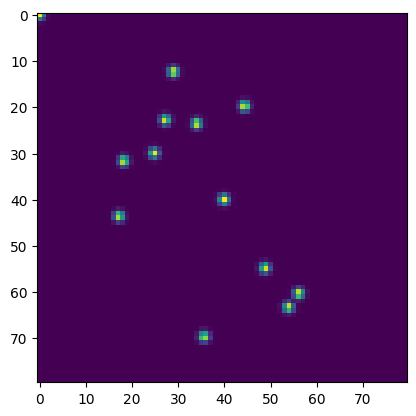

In [ ]:
x = val_ds[0]

import matplotlib.pyplot as plt

plt.imshow(x[0].permute(1, 2, 0))
plt.imshow(x[1].numpy().max(0))

In [ ]:
!pip freeze > requirements.txt

# Some of this code is redundant. I kept the previous cells un-deleted just for reference.
for i in range(5): 
    train_ds = DataGenerator(labels)
    train_dl = DataLoader(
        train_ds,
        batch_size=4,
        shuffle=True,
        num_workers=cores,
        pin_memory=True,
        drop_last=True,
        prefetch_factor=2
    )

    val_ds = DataGenerator(val_labels, is_train=False)
    val_dl = DataLoader(
        val_ds,
        batch_size=4,
        shuffle=False,
        num_workers=cores,
        pin_memory=True,
        drop_last=True,
        prefetch_factor=2
    )

    unet = Unet(filters=filters, 
                filters_rate=filters_rate, 
                down_blocks=down_blocks, 
                stem_blocks=stem_blocks, 
                up_blocks=up_blocks)

    in_channels = int(
        filters
        * (
            filters_rate
            ** (down_blocks + stem_blocks - 1 - up_blocks + 1)
        )
    )
    model = nn.Sequential(*[
        unet, 
        nn.Conv2d(in_channels=in_channels, out_channels=13, kernel_size=1, padding="same")    
    ])

    opt = torch.optim.Adam(model.parameters(), lr=1e-4)
    scaler = torch.cuda.amp.GradScaler()
    model = model.to("cuda")

    run = wandb.init(
        project="torch_vs_tf_talmo_lab", 
        name=f"torch_baseline_run{i}", 
        config={
            "is_tf": False,
            "device_and_memory": get_vram(),
            "seed": seed,
            "model_param_count": get_param_count(model)
        }, 
        tags=["baseline"],
        notes="This experiment was done in a Google Colab Notebook."
    )

    # Log dependencies.
    artifact = wandb.Artifact("Dependencies", type="dependencies")
    artifact.add_file("requirements.txt", name=f"requirements.txt")
    run.log_artifact(artifact)

    for epoch in range(3):
        _ = model.train()
        start_time = time.time()
        train_loss = 0
        for idx, batch in enumerate(train_dl):
            X, y = batch
            X = X.to("cuda")
            y = y.to("cuda")
            
            with torch.autocast("cuda"):
                y_preds = model(X)
                loss = nn.MSELoss()(y_preds, y)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            opt.zero_grad()
                    
            if idx % 100 == 0:
              print(f"Epoch: {epoch} | Loss: {loss:.5f}")

            train_loss += loss

        train_loss /= (idx+1)
        train_time = time.time() - start_time
        print(f"TRAIN: --- {train_time}s seconds ---")

        _  = model.eval()
        start_time = time.time()
        val_loss = 0
        for idx, batch in enumerate(val_dl):
            X, y = batch
            X = X.to("cuda")
            y = y.to("cuda")

            with torch.no_grad():
                y_preds = model(X)
                loss = nn.MSELoss()(y_preds, y)

            val_loss += loss

        val_loss /= (idx+1)
        val_time = time.time() - start_time
        print(f"VAL: --- {val_time}s seconds ---")

        run.log({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_time": train_time,
            "val_time": val_time,
            "total_time": train_time + val_time
        })

    del model, opt, scaler, train_ds, train_dl, val_ds, val_dl
    gc.collect()
    run.finish()

Epoch: 0 | Loss: 0.05765
Epoch: 0 | Loss: 0.00039
Epoch: 0 | Loss: 0.00031
Epoch: 0 | Loss: 0.00029
Epoch: 0 | Loss: 0.00028
Epoch: 0 | Loss: 0.00027
Epoch: 0 | Loss: 0.00028
Epoch: 0 | Loss: 0.00027
TRAIN: --- 61.90218806266785s seconds ---
VAL: --- 5.363032579421997s seconds ---
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
TRAIN: --- 60.95778775215149s seconds ---
VAL: --- 4.487998008728027s seconds ---
Epoch: 2 | Loss: 0.00026
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00026
Epoch: 2 | Loss: 0.00026
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00026
Epoch: 2 | Loss: 0.00026
TRAIN: --- 61.70762300491333s seconds ---
VAL: --- 6.7731897830963135s seconds ---


total_time,▅▁█
train_loss,█▁▁
train_time,█▁▇
val_loss,█▅▁
val_time,▄▁█
total_time,68.48081
train_loss,0.00026
train_time,61.70762
val_loss,0.00026
val_time,6.77319


Epoch: 0 | Loss: 0.01179
Epoch: 0 | Loss: 0.00042
Epoch: 0 | Loss: 0.00030
Epoch: 0 | Loss: 0.00028
Epoch: 0 | Loss: 0.00028
Epoch: 0 | Loss: 0.00027
Epoch: 0 | Loss: 0.00027
Epoch: 0 | Loss: 0.00027
TRAIN: --- 62.089590549468994s seconds ---
VAL: --- 6.622607231140137s seconds ---
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00026
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
TRAIN: --- 60.57106566429138s seconds ---
VAL: --- 4.546804428100586s seconds ---
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00026
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00026
Epoch: 2 | Loss: 0.00026
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00026
Epoch: 2 | Loss: 0.00026
TRAIN: --- 61.66666841506958s seconds ---
VAL: --- 6.935873508453369s seconds ---


total_time,█▁█
train_loss,█▁▁
train_time,█▁▆
val_loss,█▆▁
val_time,▇▁█
total_time,68.60254
train_loss,0.00026
train_time,61.66667
val_loss,0.00026
val_time,6.93587


Epoch: 0 | Loss: 0.01598
Epoch: 0 | Loss: 0.00037
Epoch: 0 | Loss: 0.00029
Epoch: 0 | Loss: 0.00028
Epoch: 0 | Loss: 0.00027
Epoch: 0 | Loss: 0.00027
Epoch: 0 | Loss: 0.00027
Epoch: 0 | Loss: 0.00027
TRAIN: --- 60.84874200820923s seconds ---
VAL: --- 7.674442291259766s seconds ---
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
TRAIN: --- 60.553605794906616s seconds ---
VAL: --- 4.426493167877197s seconds ---
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00026
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00026
Epoch: 2 | Loss: 0.00026
TRAIN: --- 60.60034894943237s seconds ---
VAL: --- 6.059931516647339s seconds ---


total_time,█▁▄
train_loss,█▁▁
train_time,█▁▂
val_loss,▇█▁
val_time,█▁▅
total_time,66.66028
train_loss,0.00027
train_time,60.60035
val_loss,0.00026
val_time,6.05993


Epoch: 0 | Loss: 0.01348
Epoch: 0 | Loss: 0.00039
Epoch: 0 | Loss: 0.00030
Epoch: 0 | Loss: 0.00028
Epoch: 0 | Loss: 0.00028
Epoch: 0 | Loss: 0.00028
Epoch: 0 | Loss: 0.00027
Epoch: 0 | Loss: 0.00027
TRAIN: --- 60.38003468513489s seconds ---
VAL: --- 4.630315780639648s seconds ---
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
TRAIN: --- 61.47210144996643s seconds ---
VAL: --- 6.7383105754852295s seconds ---
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00026
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00027
TRAIN: --- 60.27229404449463s seconds ---
VAL: --- 4.594135284423828s seconds ---


total_time,▁█▁
train_loss,█▁▁
train_time,▂█▁
val_loss,█▆▁
val_time,▁█▁
total_time,64.86643
train_loss,0.00027
train_time,60.27229
val_loss,0.00027
val_time,4.59414


Epoch: 0 | Loss: 0.01230
Epoch: 0 | Loss: 0.00036
Epoch: 0 | Loss: 0.00029
Epoch: 0 | Loss: 0.00028
Epoch: 0 | Loss: 0.00028
Epoch: 0 | Loss: 0.00028
Epoch: 0 | Loss: 0.00027
Epoch: 0 | Loss: 0.00027
TRAIN: --- 60.87558054924011s seconds ---
VAL: --- 5.160505056381226s seconds ---
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
TRAIN: --- 60.674776554107666s seconds ---
VAL: --- 4.444064378738403s seconds ---
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00026
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00026
TRAIN: --- 61.47237944602966s seconds ---
VAL: --- 7.126594066619873s seconds ---


total_time,▃▁█
train_loss,█▁▁
train_time,▃▁█
val_loss,█▄▁
val_time,▃▁█
total_time,68.59897
train_loss,0.00027
train_time,61.47238
val_loss,0.00027
val_time,7.12659
